This notebook correlates the sharptack data with Neuropixels data

## Parameters

In [1]:
animal_id = 'kms058'

In [2]:
# Parameters
animal_id = "TT002"


## Load sharptrack data

In [3]:
%reload_ext autoreload
%autoreload 2
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import xarray as xr
import seaborn as sns
import matplotlib.pylab as plt
import seaborn.objects as so
import numpy as np
from trialexp.process.anatomy import utils as anat_utils
from glob import glob
import shutil

In [4]:
base_path  = Path('/home/MRC.OX.AC.UK/ndcn1330/ettin/') # change it to your ettin path
agg_output_path = base_path/Path('Julien/Data/head-fixed/anatomy')

In [5]:
sharp_track_path_dict = {
    'kms':'Kouichi Nakamura/Analysis/Images from Otto',
    'TT': 'Teris/histology_analysis',
    'RE': 'Kouichi Nakamura/Analysis/Images from Otto'
}

In [6]:
# search for the location of the sharp track results
for id,p in sharp_track_path_dict.items():
    if id in animal_id:
        st_path = Path(p)
        break

folders = (base_path/st_path).glob('*')
sel_folder = [f for f in folders if animal_id in str(f)]
assert len(sel_folder)==1, 'Error: more than one microscopy folder found!'
sharp_track_path = sel_folder[0]/'Tapdvml_contacts.xlsx'

In [7]:
df_sharptrack = pd.read_excel(sharp_track_path)
df_sharptrack

,ap_mm,dv_mm,dv_mm_paxinos,ml_mm,annotation,name,acronym,contact_id,probe_id,depth_mm,depth_mm_paxinos,probe_AB,session_id,subject_id,probe_note,name_with_margin
0,0.030000,3.360000,2.260560,-2.520000,574,Caudoputamen,CP,1,1,1.874116,1.455460,optic fiber,NaN,NaN,NaN,Caudoputamen
1,0.030000,3.360000,2.260560,-2.520000,574,Caudoputamen,CP,2,1,1.874116,1.455460,optic fiber,NaN,NaN,NaN,Caudoputamen
2,0.036509,3.343047,2.244946,-2.528628,574,Caudoputamen,CP,3,1,1.854116,1.439928,optic fiber,NaN,NaN,NaN,Caudoputamen
3,0.036509,3.343047,2.244946,-2.528628,574,Caudoputamen,CP,4,1,1.854116,1.439928,optic fiber,NaN,NaN,NaN,Caudoputamen
4,0.043017,3.326094,2.229333,-2.537256,574,Caudoputamen,CP,5,1,1.834116,1.424395,optic fiber,NaN,NaN,NaN,Caudoputamen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,1.082685,2.312408,1.295728,-2.639158,21,Primary motor area Layer 2/3,MOp2/3,380,3,0.595101,0.518923,A,TT002-2023-07-04-124931,NaN,NaN,Primary motor area Layer 2/3
1148,1.087672,2.293373,1.278197,-2.643280,21,Primary motor area Layer 2/3,MOp2/3,381,3,0.575101,0.501483,A,TT002-2023-07-04-124931,NaN,NaN,Primary motor area Layer 2/3
1149,1.087672,2.293373,1.278197,-2.643280,21,Primary motor area Layer 2/3,MOp2/3,382,3,0.575101,0.501483,A,TT002-2023-07-04-124931,NaN,NaN,Primary motor area Layer 2/3
1150,1.092660,2.274338,1.260666,-2.647403,21,Primary motor area Layer 2/3,MOp2/3,383,3,0.555101,0.484043,A,TT002-2023-07-04-124931,NaN,NaN,Primary motor area Layer 2/3


### Load neuropixel results

In [8]:
path = base_path/Path('Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22')
files = list(Path(path).glob(f'{animal_id}*/processed/xr_spikes_trials.nc'))
files

[PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT002-2023-07-06-120338/processed/xr_spikes_trials.nc'),
 PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT002-2023-07-04-124931/processed/xr_spikes_trials.nc')]

In [9]:
# extract the firing rate and maxwaveformCh from the xr_spikes_trials.nc xarray dataset
data_list = []
for i in tqdm(range(len(files))):
    dataset = xr.open_dataset(files[i])
    da = dataset[['firingRate','maxWaveformCh1']]
    data_list.append(da)

if len(data_list) ==0:
    raise FileNotFoundError(f'Cannot file spike sorting results for {animal_id}')
    
cell_da = xr.merge(data_list)


  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
# format the dataframe for later merging
df_cell = cell_da.to_dataframe().reset_index()
df_cell = anat_utils.format_cell4merge(df_cell)
df_cell

,cluID,firingRate,maxWaveformCh1,session_id,probe,id,session_date
0,TT002-2023-07-04-124931_ProbeA_0,9.146537,4.0,TT002-2023-07-04-124931,A,0,TT002-2023-07-04
1,TT002-2023-07-04-124931_ProbeA_1,2.163077,3.0,TT002-2023-07-04-124931,A,1,TT002-2023-07-04
2,TT002-2023-07-04-124931_ProbeA_10,30.968579,14.0,TT002-2023-07-04-124931,A,10,TT002-2023-07-04
3,TT002-2023-07-04-124931_ProbeA_1000,0.090730,298.0,TT002-2023-07-04-124931,A,1000,TT002-2023-07-04
4,TT002-2023-07-04-124931_ProbeA_1001,0.957410,298.0,TT002-2023-07-04-124931,A,1001,TT002-2023-07-04
...,...,...,...,...,...,...,...
1231,TT002-2023-07-06-120338_ProbeA_946,0.717811,378.0,TT002-2023-07-06-120338,A,946,TT002-2023-07-06
1232,TT002-2023-07-06-120338_ProbeA_95,0.400043,42.0,TT002-2023-07-06-120338,A,95,TT002-2023-07-06
1233,TT002-2023-07-06-120338_ProbeA_96,0.081109,42.0,TT002-2023-07-06-120338,A,96,TT002-2023-07-06
1234,TT002-2023-07-06-120338_ProbeA_98,4.206787,41.0,TT002-2023-07-06-120338,A,98,TT002-2023-07-06


### Match sharptrack to cluster

In [11]:
# There may be multiple recordings on the same date, but usually only 1 probe penetration
# so here we merge based on the date instead of the sesison_id

df_sharptrack['session_date'] = df_sharptrack['session_id'].apply(anat_utils.get_session_date)

df_cell_merge = df_cell.merge(df_sharptrack, left_on=['session_date','probe','maxWaveformCh1'],
                              right_on = ['session_date', 'probe_AB','contact_id'])
df_cell_merge.head()

,cluID,firingRate,maxWaveformCh1,session_id_x,probe,id,session_date,ap_mm,dv_mm,dv_mm_paxinos,...,acronym,contact_id,probe_id,depth_mm,depth_mm_paxinos,probe_AB,session_id_y,subject_id,probe_note,name_with_margin
0,TT002-2023-07-04-124931_ProbeA_0,9.146537,4.0,TT002-2023-07-04-124931,A,0,TT002-2023-07-04,0.144988,5.890965,4.591579,...,FS,4,3,4.355101,3.797608,A,TT002-2023-07-04-124931,NaN,NaN,boundary
1,TT002-2023-07-04-124931_ProbeA_1,2.163077,3.0,TT002-2023-07-04-124931,A,1,TT002-2023-07-04,0.144988,5.890965,4.591579,...,FS,3,3,4.355101,3.797608,A,TT002-2023-07-04-124931,NaN,NaN,boundary
2,TT002-2023-07-04-124931_ProbeA_2,2.092680,3.0,TT002-2023-07-04-124931,A,2,TT002-2023-07-04,0.144988,5.890965,4.591579,...,FS,3,3,4.355101,3.797608,A,TT002-2023-07-04-124931,NaN,NaN,boundary
3,TT002-2023-07-04-124931_ProbeA_10,30.968579,14.0,TT002-2023-07-04-124931,A,10,TT002-2023-07-04,0.169926,5.795791,4.503923,...,STR,14,3,4.255101,3.710409,A,TT002-2023-07-04-124931,NaN,NaN,Striatum
4,TT002-2023-07-04-124931_ProbeA_1000,0.090730,298.0,TT002-2023-07-04-124931,A,1000,TT002-2023-07-04,0.878187,3.092838,2.014504,...,MOp6a,298,3,1.415101,1.233955,A,TT002-2023-07-04-124931,NaN,NaN,boundary


In [12]:
df_cell_probe= df_cell_merge[(df_cell_merge.probe_AB=='A') & (df_cell_merge.session_date == 'kms058-2023-03-23')].copy()
df_cell_probe.head()

,cluID,firingRate,maxWaveformCh1,session_id_x,probe,id,session_date,ap_mm,dv_mm,dv_mm_paxinos,...,acronym,contact_id,probe_id,depth_mm,depth_mm_paxinos,probe_AB,session_id_y,subject_id,probe_note,name_with_margin


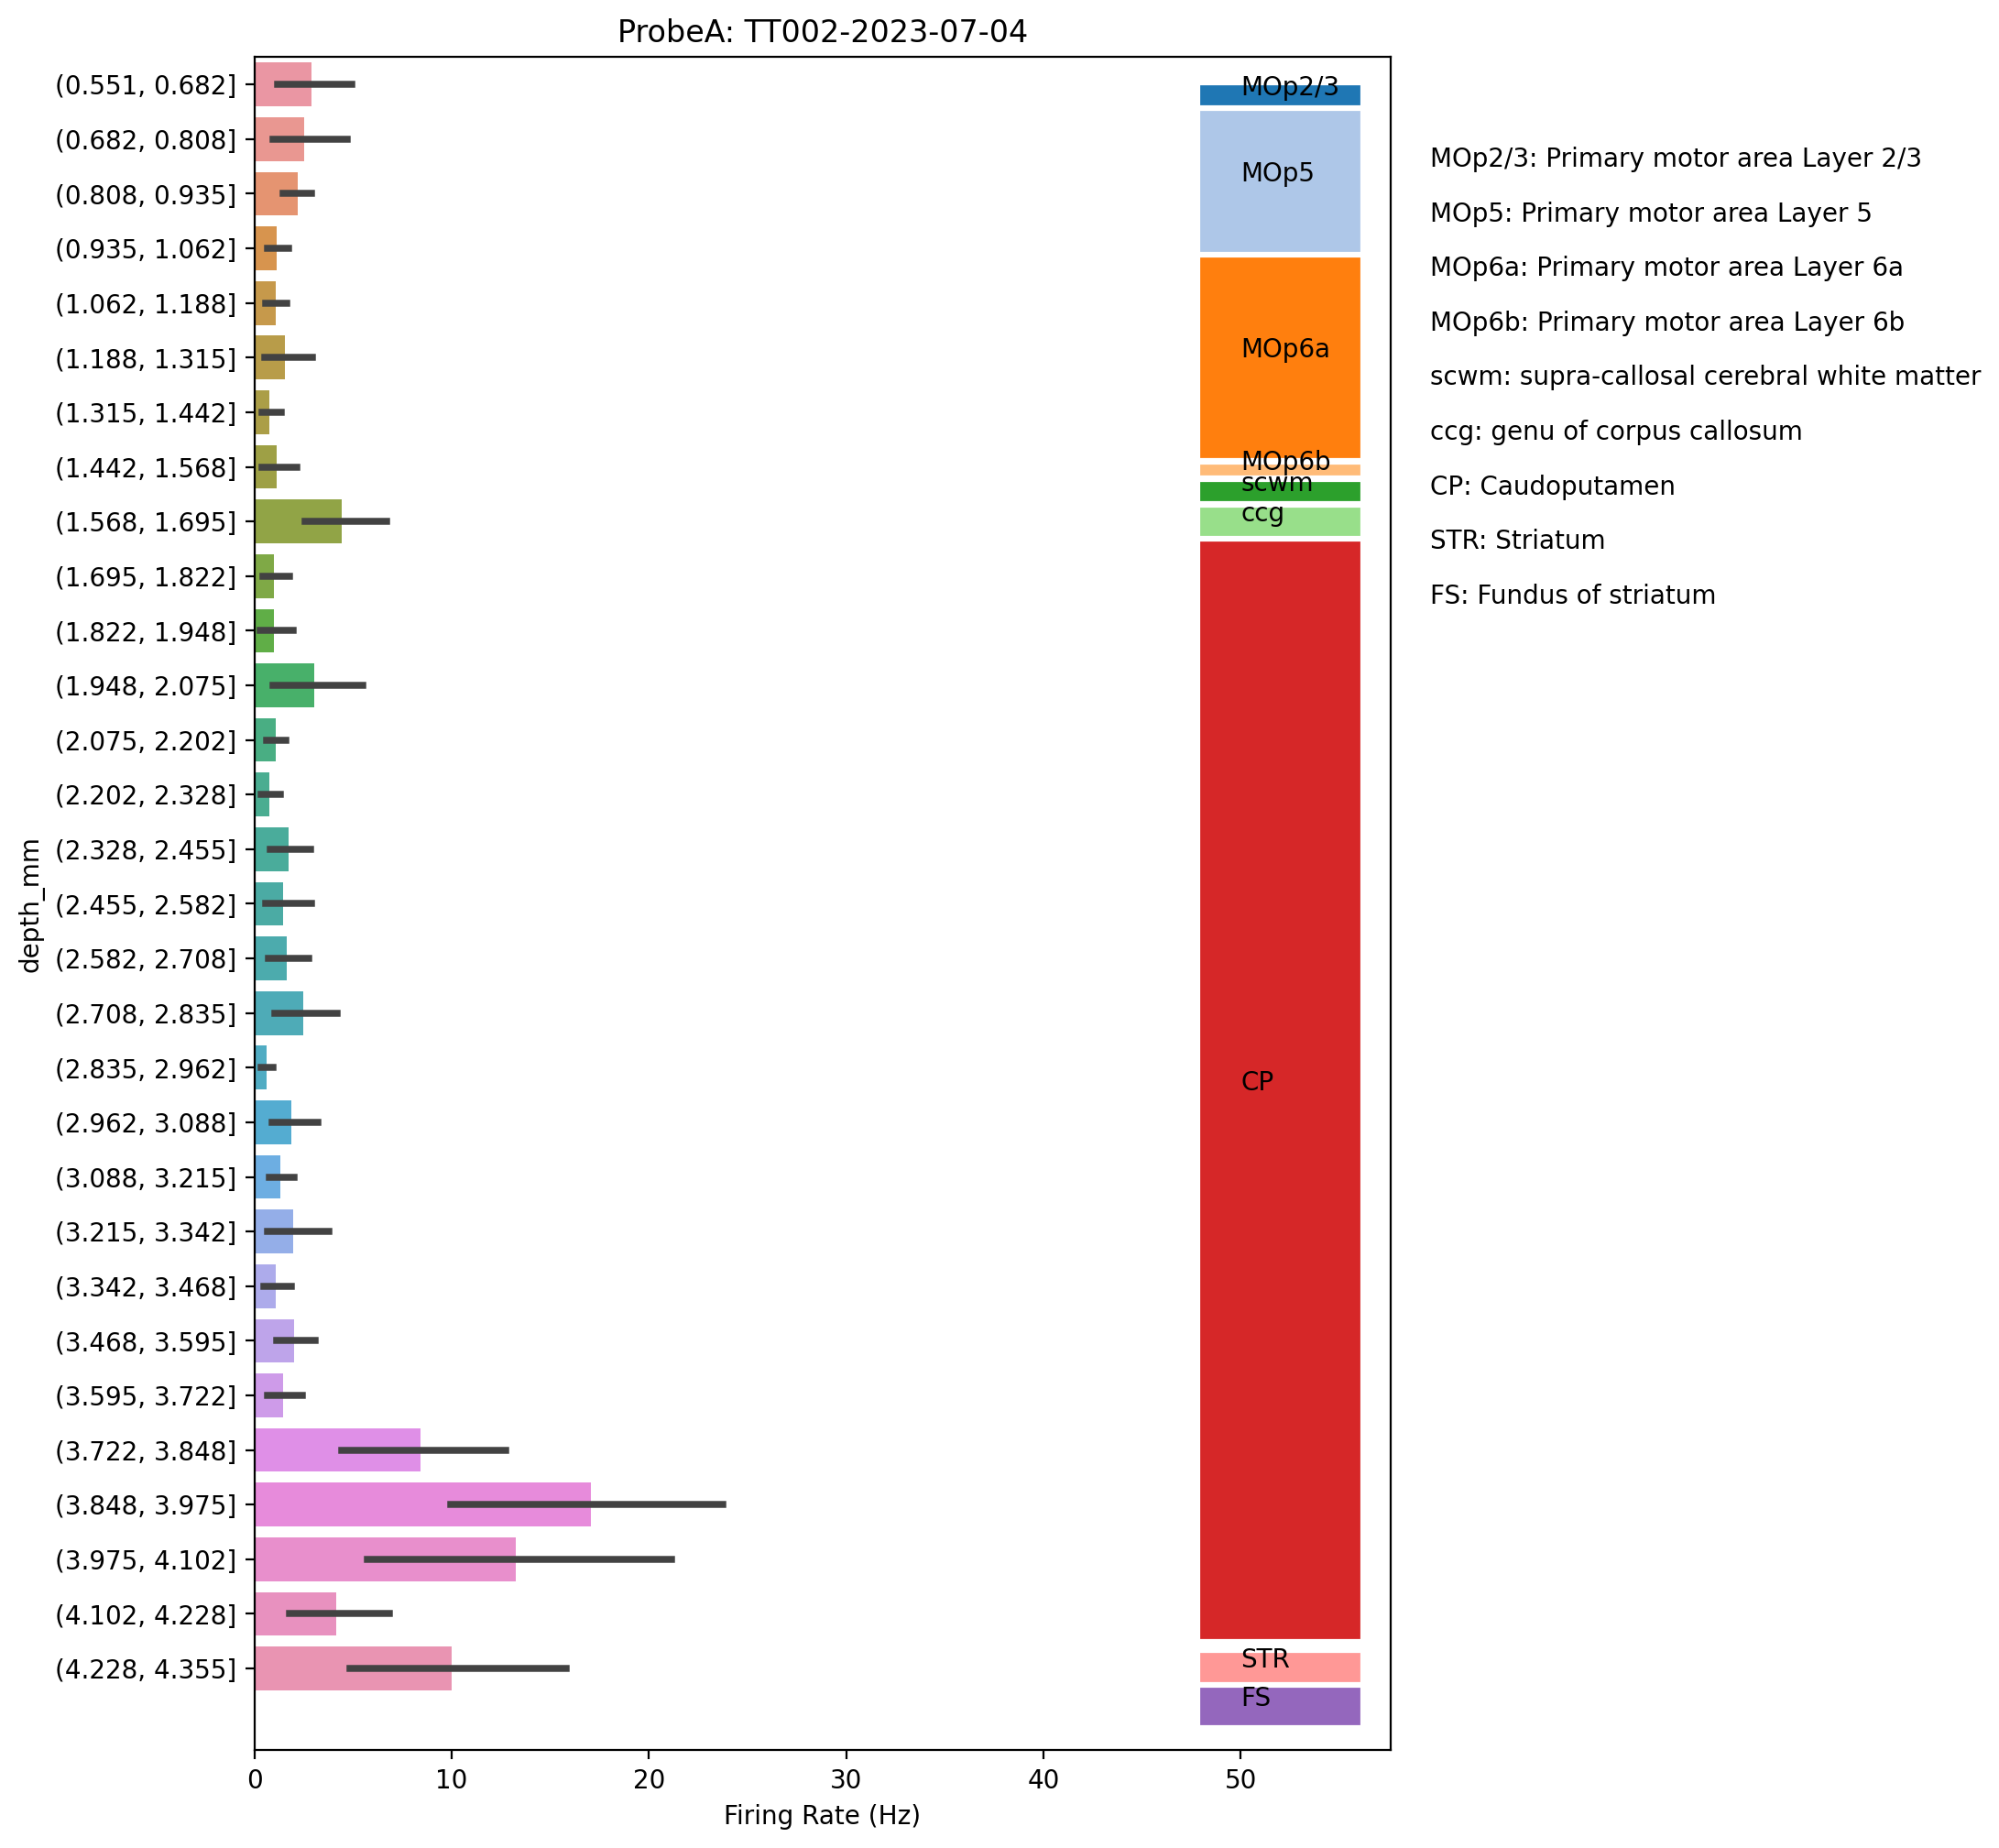

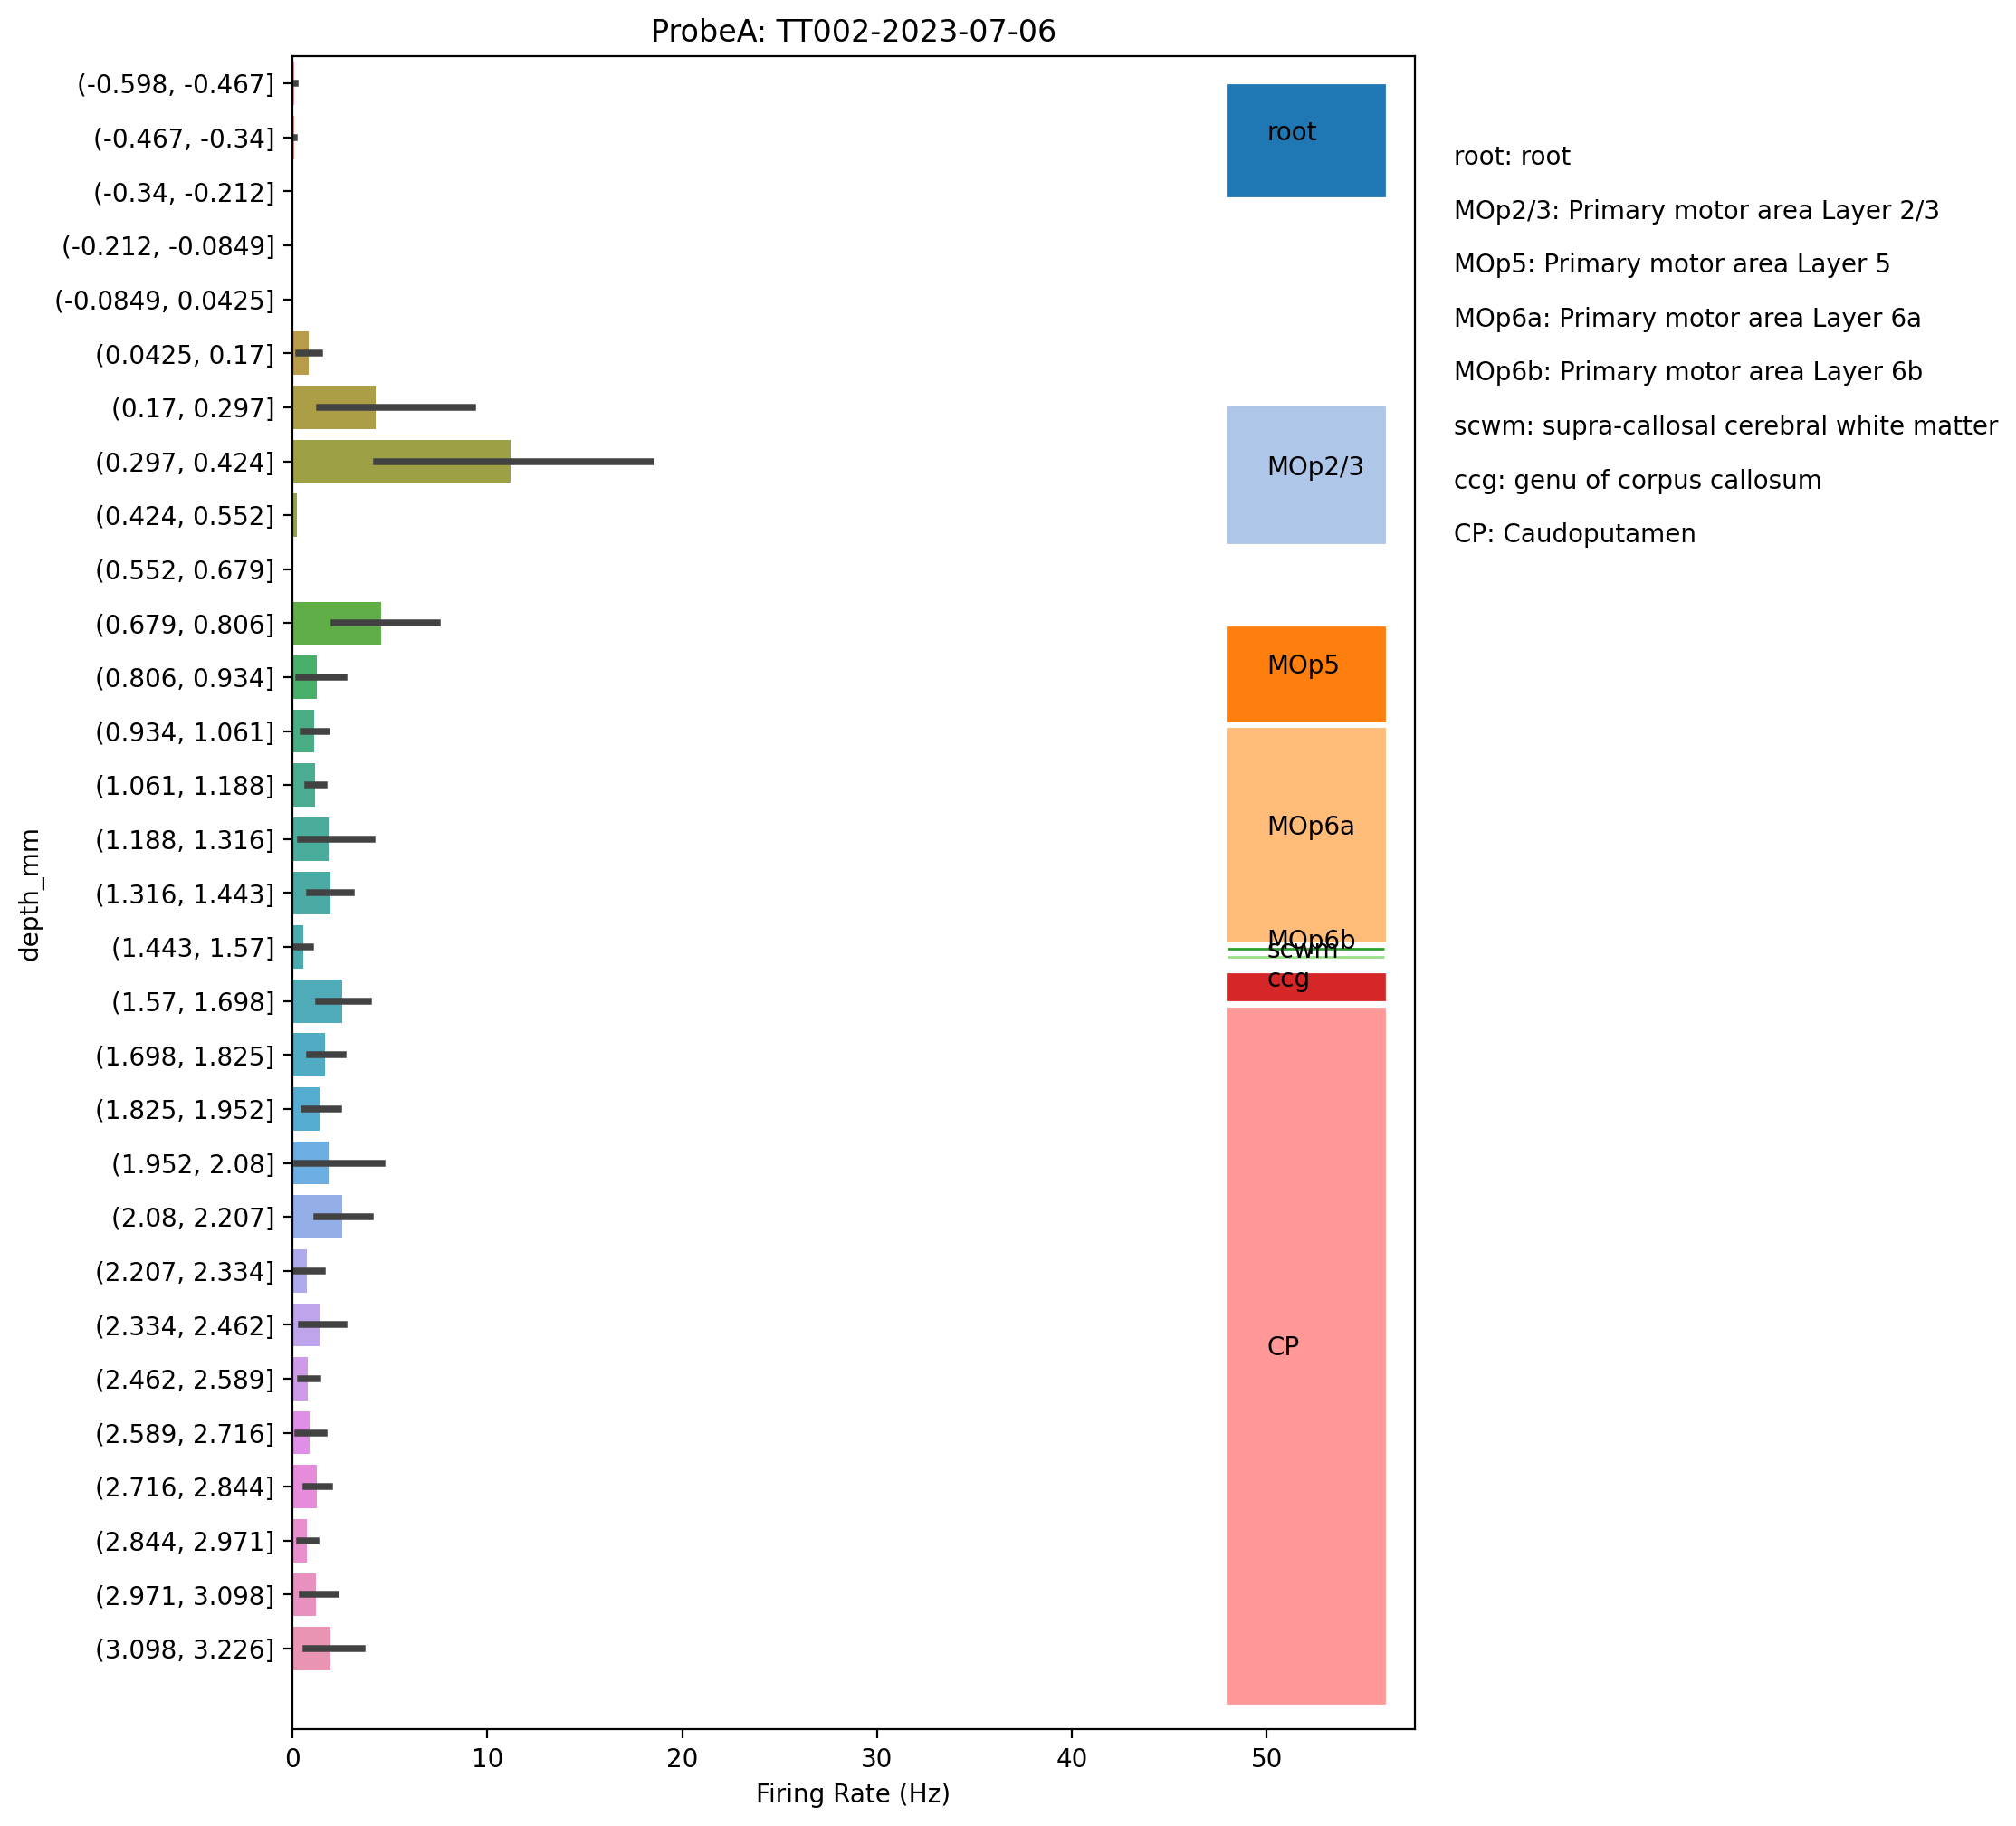

In [13]:
# TODO: figure out the best way to display aggregated data from multiple sessions
figure_output_path = sharp_track_path.parent/'ephys'

if not figure_output_path.exists():
    figure_output_path.mkdir()

for session_date in df_cell_merge.session_date.unique():
    for probe in ['A','B']:
        df_cell_probe= df_cell_merge[(df_cell_merge.probe_AB==probe) & (df_cell_merge.session_date == session_date)].copy()
        if len(df_cell_probe)>0:
            ax = anat_utils.plot_firing_rate_regions(df_cell_probe)
            ax.set_title(f'Probe{probe}: {session_date}')
            plt.savefig(figure_output_path/f'FiringRate_depth_Probe{probe}_{session_date}.png',dpi=200, bbox_inches='tight')

## Also plot aggregated firing rate in different brain regions

### Firing rate

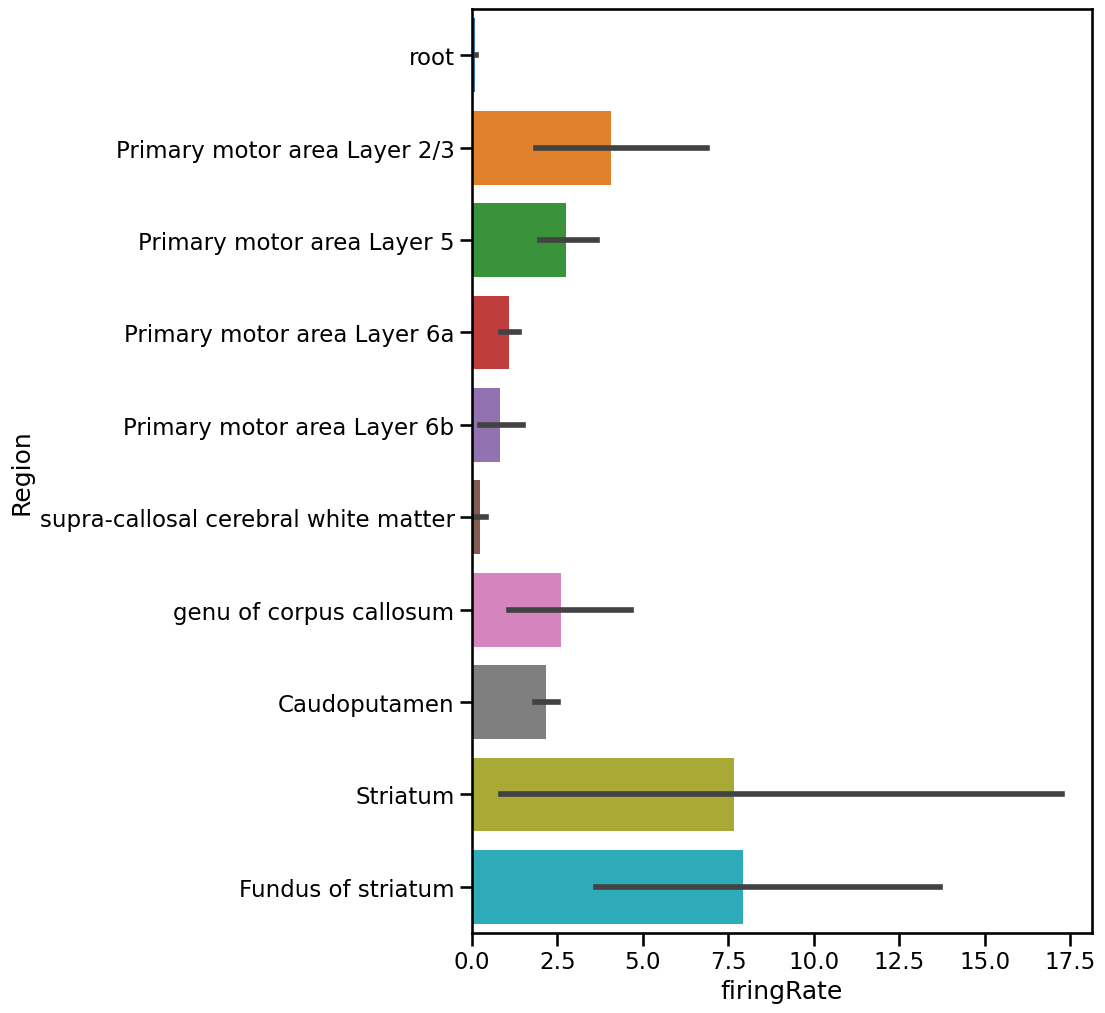

In [14]:
plt.figure(figsize=(8,12))
sns.set_context('talk')
df2plot = df_cell_merge
region_position = df2plot.groupby('name')['dv_mm'].mean().sort_values()
ax = sns.barplot(df2plot, y='name', x='firingRate', order=region_position.index)
ax.set_ylabel('Region')
plt.savefig(figure_output_path/'firing_rate_regions.png',dpi=300,bbox_inches='tight')

### Cell counts

<Figure size 800x1200 with 0 Axes>

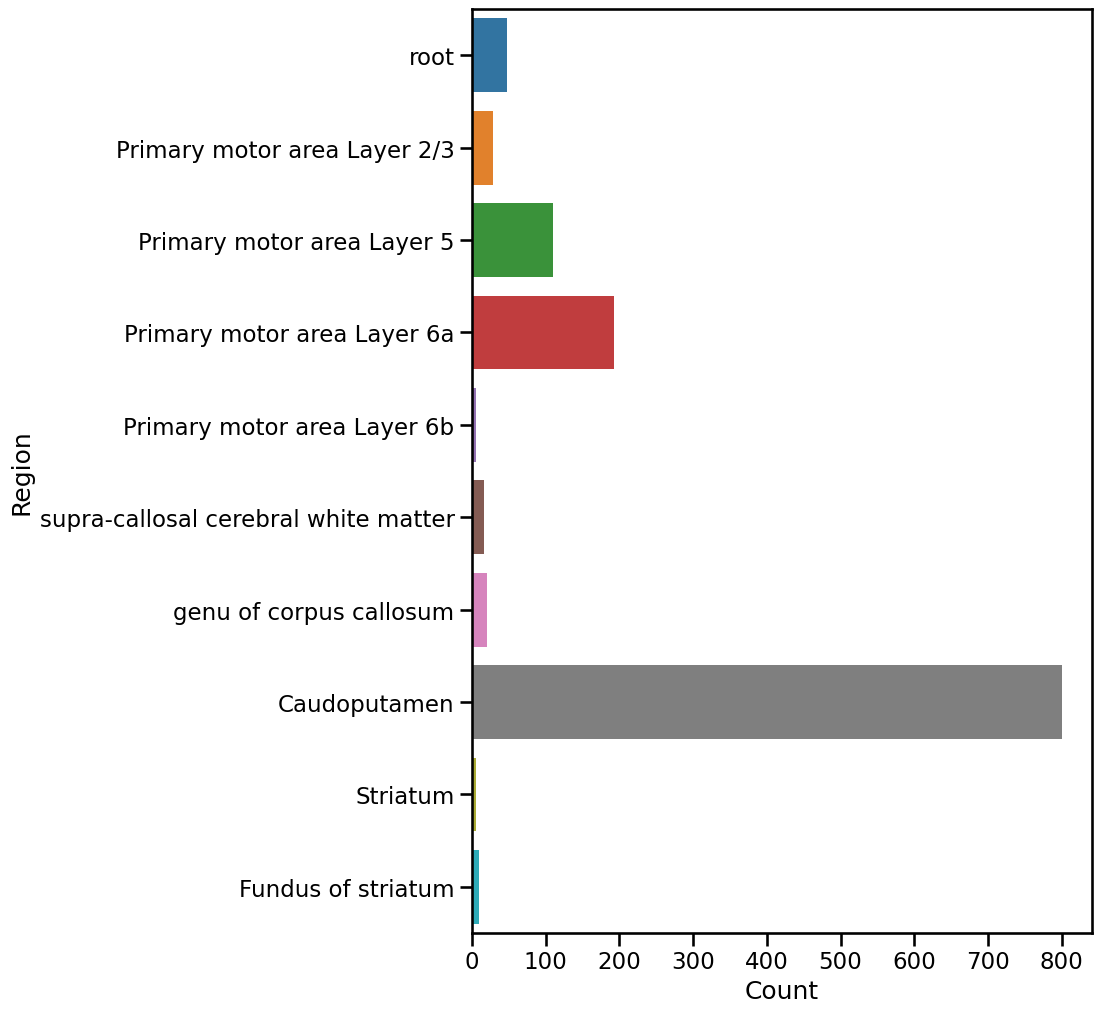

In [15]:
plt.figure(figsize=(8,12))
cell_count = df2plot.groupby('name')['cluID'].count().reset_index()
plt.figure(figsize=(8,12))
ax = sns.barplot(cell_count, x='cluID', y='name', order=region_position.index)
ax.set_xlabel('Count')
ax.set_ylabel('Region')

plt.savefig(figure_output_path/'cell_count_regions.png',dpi=300,bbox_inches='tight')

## Copy outputs

In [16]:
# also copy all outputs to a central location
dest_path = agg_output_path/'sharp_track'/animal_id

shutil.copytree(figure_output_path, dest_path, dirs_exist_ok=True)
df_sharptrack.to_pickle(dest_path/'df_sharptrack.pkl')
df_cell_merge.to_pickle(dest_path/'df_cell_merge.pkl')